## Getting the data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
from pathlib import Path
warnings.filterwarnings("ignore")
plt.style.use("seaborn")

In [24]:
data = pd.read_csv(
Path("../data/DOGEUSDT1H.csv"), parse_dates = ["Date"], index_col = "Date")

data.columns=(["Open", "High", "Low", "Close", "Volume"])

data = data[["Close"]].copy()

data["returns"] = np.log(data.Close.div(data.Close.shift(1)))


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21906 entries, 2019-01-01 00:00:00 to 2021-07-01 17:00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Close    21906 non-null  float64
 1   returns  21905 non-null  float64
dtypes: float64(2)
memory usage: 513.4 KB


In [32]:
SMA_S = 15
SMA_M = 50
SMA_L = 200

data["SMA_S"] = data.Close.rolling(window = SMA_S).mean()
data["SMA_M"] = data.Close.rolling(window = SMA_M).mean()
data["SMA_L"] = data.Close.rolling(window = SMA_L).mean()

data

In [35]:
data.dropna(inplace = True)

In [38]:
smas = ["SMA_S", "SMA_M", "SMA_L"]
smas

data["position"] = 0 # Trading position -> Neutral for all bars
data.tail(5)

cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
cond1

cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)
cond2

data.loc[cond1, "position"] = 1
data.loc[cond2, "position"] = -1

In [42]:
data.position.value_counts()

 0    9007
-1    6903
 1    5797
Name: position, dtype: int64

In [44]:
data.tail()

,Close,returns,SMA_S,SMA_M,SMA_L,position
Date,,,,,,
2021-07-01 13:00:00,0.1692,0.004739,0.170540,0.171126,0.173830,-1
2021-07-01 14:00:00,0.1691,-0.000591,0.170420,0.171042,0.173716,-1
2021-07-01 15:00:00,0.1692,0.000591,0.170267,0.170956,0.173604,-1
2021-07-01 16:00:00,0.1684,-0.004739,0.170087,0.170854,0.173491,-1
2021-07-01 17:00:00,0.1693,0.005330,0.170000,0.170748,0.173383,-1


## Backtesting

In [83]:
class Long_Short_Backtester():
    ''' Class for backtesting of Long-Short trading strategy
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy.
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Long_Short_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw
        
    def test_strategy(self, smas):
        '''
        Parameters
        ============
        smas: (SMA_S, SMA_M, SMA_L)
            Simple Moving Averages to be considered for the strategy.
            
        '''
        
        self.SMA_S = smas[0]
        self.SMA_M = smas[1]
        self.SMA_L = smas[2]
        
        
        self.prepare_data(smas = smas)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, smas):
        ''' Prepares the Data for Backtesting.
        '''
        ########################## Strategy-Specific #############################
        
        data = self.data[["Close", "returns"]].copy()
        data["SMA_S"] = data.Close.rolling(window = smas[0]).mean()
        data["SMA_M"] = data.Close.rolling(window = smas[1]).mean()
        data["SMA_L"] = data.Close.rolling(window = smas[2]).mean()
        
        data.dropna(inplace = True)
                
        cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
        cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)
        
        data["position"] = 0
        data.loc[cond1, "position"] = 1
        data.loc[cond2, "position"] = -1

        ##########################################################################
        
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            


    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
       
        print(100 * "=")
        print("TRIPLE SMA STRATEGY | INSTRUMENT = {} | SMAs = {}".format(self.symbol, [self.SMA_S, self.SMA_M, self.SMA_L]))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)
     

In [84]:
filepath = ("../data/DOGEUSDT1H.csv")
symbol = "DOGEUSDT"
start = "2019-01-01"
end = "2021-07-01"
tc = -0.00085 # futures trading cost
sma_s = 15 
sma_m = 50 
sma_l = 200 

In [85]:


tester = Long_Short_Backtester(filepath = filepath, symbol = symbol,
                              start = start, end = end, tc = tc)

In [86]:
tester.data

,Open,High,Low,Close,Volume,returns
Date,,,,,,
2019-01-01 00:00:00,0.003915,0.003928,0.003765,0.003835,159004267.0,NaN
2019-01-01 01:00:00,0.003845,0.003920,0.003814,0.003841,105517060.0,0.001563
2019-01-01 02:00:00,0.003837,0.003869,0.003710,0.003738,100804728.0,-0.027287
2019-01-01 03:00:00,0.003728,0.003734,0.003636,0.003666,120261079.0,-0.019314
2019-01-01 04:00:00,0.003659,0.003680,0.003550,0.003628,148274922.0,-0.010639
...,...,...,...,...,...,...
2021-07-01 13:00:00,0.168500,0.169500,0.168000,0.169200,16706908.0,0.004739
2021-07-01 14:00:00,0.169200,0.169600,0.168700,0.169100,17197978.0,-0.000591
2021-07-01 15:00:00,0.169000,0.169600,0.168400,0.169200,16450100.0,0.000591


In [87]:
tester.test_strategy(smas = (sma_s, sma_m, sma_l))

TRIPLE SMA STRATEGY | INSTRUMENT = DOGEUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         89.805274
Multiple (Buy-and-Hold):     52.756224
--------------------------------------
Out-/Underperformance:       37.04905


CAGR:                        5.154707
Annualized Mean:             1.817874
Annualized Std:              1.40085
Sharpe Ratio:                3.679698


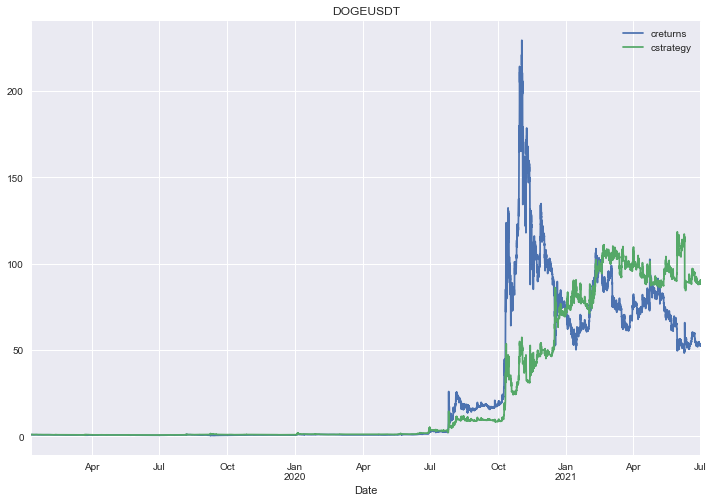

In [88]:
tester.plot_results()

In [ ]:
tester.results

,Close,returns,SMA_S,SMA_M,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,
2019-01-09 07:00:00,0.003142,-0.021163,0.003183,0.003234,0.003422,-1,NaN,0.0,0.979060,NaN
2019-01-09 08:00:00,0.003206,0.020259,0.003183,0.003234,0.003419,-1,-0.020259,0.0,0.999096,0.979945
2019-01-09 09:00:00,0.003208,0.000592,0.003184,0.003235,0.003415,-1,-0.000592,0.0,0.999688,0.979365
2019-01-09 10:00:00,0.003253,0.013960,0.003188,0.003236,0.003413,-1,-0.013960,0.0,1.013742,0.965788
2019-01-09 11:00:00,0.003249,-0.001200,0.003190,0.003236,0.003411,-1,0.001200,0.0,1.012527,0.966947
...,...,...,...,...,...,...,...,...,...,...
2021-07-01 13:00:00,0.169200,0.004739,0.170540,0.171126,0.173830,-1,-0.004739,0.0,52.725063,89.858350
2021-07-01 14:00:00,0.169100,-0.000591,0.170420,0.171042,0.173716,-1,0.000591,0.0,52.693902,89.911490
2021-07-01 15:00:00,0.169200,0.000591,0.170267,0.170956,0.173604,-1,-0.000591,0.0,52.725063,89.858350


In [36]:
tester.results.trades.value_counts()

0.0    30756
1.0      963
2.0        4
Name: trades, dtype: int64